In [1]:
"""
Stress Testing Equity Dispersion with Elastic Net vs Linear Regression

This script:
- Downloads daily market + macro data from free APIs
- Builds 21-day rolling realized volatility of S&P 500 daily returns as the target (dispersion proxy)
- Engineers lagged and rolling features for macro/market drivers
- Validates that dispersion spikes during COVID (sanity check)
- Trains a baseline OLS model and an Elastic Net model with time-series CV
- Compares RMSE and reports best hyperparameters and feature importances
"""

import math
import datetime as dt
from dataclasses import dataclass
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas_datareader.data as web
from pandas_datareader import data as pdr

from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# --------------------------------------------------------------------
# 0. PARAMETERS
# --------------------------------------------------------------------

@dataclass
class ModelParams:
    # Time window
    end_date: dt.date = dt.date.today()
    lookback_years: int = 6.5  # last N years

    # Symbols (Stooq / logical)
    sp500_symbol: str = "^GSPC"       # S&P 500 index (mapped from SPX)
    vxx_symbol: str = "VXX.US"        # mapped from VXX.US
    hyg_symbol: str = "HYG"           # mapped from HYG.US
    lqd_symbol: str = "LQD"           # mapped from LQD.US

    # FRED series IDs
    fred_series: Dict[str, str] = None

    # Rolling windows and lags
    vol_window: int = 21
    macro_lag_days: int = 10

    # Train/test split, CV
    test_size_fraction: float = 0.35
    n_splits: int = 10
    max_iter: int = 10000
    l1_ratios: np.ndarray = np.linspace(0.5, 1.0, 11)
    alphas: np.ndarray = np.logspace(-3, 1, 50)
    top_n_features: int = 10
    top_n_models: int = 10

    def __post_init__(self):
        if self.fred_series is None:
            self.fred_series = {
                "EFFR": "EFFR",      # Effective Fed Funds Rate
                "BAA10Y": "BAA10Y",
            }


def compute_start_date(params: ModelParams) -> dt.date:
    return params.end_date - dt.timedelta(days=365 * params.lookback_years)


# --------------------------------------------------------------------
# 1. DATA DOWNLOAD
# --------------------------------------------------------------------

def download_market_data_stooq(params: ModelParams) -> pd.DataFrame:
    """
    Download daily OHLCV data for key market series from Stooq via pandas_datareader.
    We will use the 'Close' column as the price proxy (similar to Adj Close).

    Stooq tickers:
    - '^SPX'  : S&P 500 index
    - 'HYG.US': HYG ETF (US listing)
    - 'LQD.US': LQD ETF (US listing)
    - 'VXX.US'  : VXX
    """
    start_date = compute_start_date(params)
    end_date = params.end_date

    # Map our logical names to Stooq tickers
    stooq_tickers = {
        "SPX": "^SPX",
        "HYG": "HYG.US",
        "LQD": "LQD.US",
        "VXX": "VXX.US",
    }

    frames = []
    for name, ticker in stooq_tickers.items():
        df_t = web.DataReader(ticker, "stooq", start_date, end_date)
        # Stooq returns most recent first; sort ascending by date
        df_t = df_t.sort_index()
        print(name, ticker, df_t.columns)
        # Keep Close column only and rename to logical name
        df_t = df_t[["Close"]].rename(columns={"Close": name})
        frames.append(df_t)

    market_df = pd.concat(frames, axis=1)

    # Rename columns to match what the rest of the code expects
    market_df.rename(
        columns={
            "SPX": params.sp500_symbol,      # "^GSPC" in your params
            "HYG": params.hyg_symbol,        # "HYG"
            "LQD": params.lqd_symbol,        # "LQD"
            "VXX": params.vxx_symbol,        # "VXX.US"
        },
        inplace=True,
    )

    return market_df


def download_fred_data(params: ModelParams) -> pd.DataFrame:
    """
    Download macro series from FRED (global free data).
    """
    start_date = compute_start_date(params)
    fred_ids = list(params.fred_series.values())
    fred_df = pdr.get_data_fred(fred_ids, start=start_date, end=params.end_date)
    fred_df = fred_df.sort_index()

    # Rename columns to the human-readable keys defined in params
    fred_df.rename(columns={v: k for k, v in params.fred_series.items()}, inplace=True)
    return fred_df


def merge_market_macro(market_df: pd.DataFrame, macro_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge market and macro data on date index, forward-filling low-frequency macro data.
    """
    df = market_df.join(macro_df, how="inner")
    # Forward-fill macro series (monthly/weekly) to align with daily market data
    df = df.ffill()
    df = df.dropna(how="all")
    return df

In [2]:
# --------------------------------------------------------------------
# 2. FEATURE ENGINEERING
# --------------------------------------------------------------------

def compute_sp500_vol(df: pd.DataFrame, params: ModelParams) -> pd.Series:
    """
    Compute 21-day rolling realized volatility of S&P 500 daily returns.
    This is the dependent variable (Y): equity dispersion proxy.
    """
    sp = df[params.sp500_symbol]
    returns = sp.pct_change()
    # 21-day rolling standard deviation of daily returns, annualized
    vol = returns.rolling(window=params.vol_window).std() * np.sqrt(252)
    vol = vol.clip(lower=1e-6)  # avoid log(0)
    vol = np.log(vol) # Use log‑vol to stabilize scale, since extreme spikes dominate the loss
    vol.name = "SPX_21D_REALIZED_VOL"
    return vol


def build_feature_frame(df: pd.DataFrame, params: ModelParams) -> pd.DataFrame:
    """
    Build a feature DataFrame with:
    - Y: 21-day realized volatility of S&P 500
    - X: macro/market drivers (transformed and lagged where appropriate)
    """

    # 1) Target variable (Y)
    y = compute_sp500_vol(df, params)
    # Volatility persistence: previous day's vol
    vol_lag = y.shift(21).rename("VOL_LAG") # Volatility persistence (lag of Y) 
    
    # 2) Base daily returns for some series
    sp_ret = df[params.sp500_symbol].pct_change().rename("SP_RET")
    hyg_ret = df[params.hyg_symbol].pct_change().rename("HYG_RET")
    lqd_ret = df[params.lqd_symbol].pct_change().rename("LQD_RET")
    vxx_ret = df[params.vxx_symbol].pct_change().rename("VXX_RET")  
    
    # Interaction: equity return × VXX: captures joint risk‑on / risk‑off behaviour between equities and volatility ETN.
    sp_x_vxx = (sp_ret * vxx_ret).rename("SP_RET_X_VXX")

    # 3) Credit spread proxy (high yield vs investment grade)
    credit_spread = (df[params.hyg_symbol] - df[params.lqd_symbol]).rename("CREDIT_SPREAD")
    credit_spread_sq = (credit_spread ** 2).rename("CREDIT_SPREAD_SQ") # Squared credit spread
    credit_spread_change = credit_spread.diff().rename("CREDIT_SPREAD_DIFF")
    
    # Interaction: HY return × credit spread: reflects that HY moves are more important when spreads are already wide.
    hyg_x_spread = (hyg_ret * credit_spread).rename("HYG_RET_X_SPREAD") 


    # 4) Rates and macro
    effr = df["EFFR"]
    baa10y = df["BAA10Y"]

    # 6) Simple transformations / lags (approximate stationarity)
    # Lag macro-type variables by macro_lag_days to simulate info set
    lag = params.macro_lag_days
    effr_lag = effr.shift(lag).rename("EFFR_LAG")
    baa10y_lag = baa10y.shift(lag).rename("BAA10Y_LAG")

    # Assemble into one DataFrame
    features = pd.concat(
        [
            y,
            vol_lag,  
            sp_ret,
            hyg_ret,
            lqd_ret,
            vxx_ret,
            sp_x_vxx,  
            credit_spread,
            credit_spread_sq, 
            credit_spread_change,
            hyg_x_spread,  
            effr_lag,
            baa10y_lag,
        ],
        axis=1,
    )

    # Drop rows where Y is NaN (first vol_window-1 days)
    features = features.dropna(subset=["SPX_21D_REALIZED_VOL"])

    return features


# --------------------------------------------------------------------
# 3. DIAGNOSTIC: DISPERSION SANITY CHECK
# --------------------------------------------------------------------

def dispersion_diagnostics(df_features: pd.DataFrame) -> None:
    """
    Plot the dispersion series and print the maximum value and date,
    as a sanity check (e.g., COVID spike).
    """
    y = df_features["SPX_21D_REALIZED_VOL"]

    plt.figure(figsize=(10, 4))
    plt.plot(y.index, y.values, label="21D Realized Vol (S&P 500)")
    plt.title("21-Day Realized Volatility of S&P 500")
    plt.ylabel("Annualized Volatility")
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    max_val = y.max()
    max_date = y.idxmax()
    print(f"Max dispersion (21D realized vol) = {max_val:.4f} on {max_date.date()}")


In [3]:
# --------------------------------------------------------------------
# 4. TRAIN / TEST SPLIT (TIME SERIES)
# --------------------------------------------------------------------

def time_series_train_test_split(
    df_features: pd.DataFrame, params: ModelParams
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:

    """
    Split features into train/test sets by time, preserving chronological order.
    """
    df_features = df_features.dropna()
    n = len(df_features)
    test_size = int(np.floor(params.test_size_fraction * n))
    train_size = n - test_size

    train = df_features.iloc[:train_size]
    test = df_features.iloc[train_size:]

    X_train = train.drop(columns=["SPX_21D_REALIZED_VOL"])
    y_train = train["SPX_21D_REALIZED_VOL"]
    X_test = test.drop(columns=["SPX_21D_REALIZED_VOL"])
    y_test = test["SPX_21D_REALIZED_VOL"]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {X_train.index[0].date()} to {X_train.index[-1].date()}")
    print(f"Test period:  {X_test.index[0].date()} to {X_test.index[-1].date()}")
    return X_train, X_test, y_train, y_test

In [4]:
# --------------------------------------------------------------------
# 5. MODELING: SCALING, OLS BASELINE, ELASTIC NET CV
# --------------------------------------------------------------------

def fit_models_with_timeseries_cv(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    params: ModelParams,
):
    """
    Fit:
    - Baseline Linear Regression (OLS)
    - Elastic Net with TimeSeriesSplit CV (over l1_ratio and alpha grid)

    Returns:
    - dict with models, RMSEs, best hyperparams, coefficients, and CV summary.
    """

    # ----------------------------
    # Standardize features (fit only on train)
    # ----------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----------------------------
    # Baseline OLS
    # ----------------------------
    ols = LinearRegression()
    ols.fit(X_train_scaled, y_train)
    y_pred_ols = ols.predict(X_test_scaled)
    rmse_ols = math.sqrt(mean_squared_error(y_test, y_pred_ols))

    print(f"\nBaseline OLS Test RMSE: {rmse_ols:.6f}")

    # ----------------------------
    # Elastic Net with TimeSeriesSplit
    # ----------------------------
    tscv = TimeSeriesSplit(n_splits=params.n_splits)

    enet = ElasticNetCV(
        l1_ratio=params.l1_ratios,
        alphas=params.alphas,
        cv=tscv,
        max_iter=params.max_iter,
        n_jobs=-1,
    )

    enet.fit(X_train_scaled, y_train)
    y_pred_enet = enet.predict(X_test_scaled)
    rmse_enet = math.sqrt(mean_squared_error(y_test, y_pred_enet))

    print(f"Elastic Net Test RMSE: {rmse_enet:.6f}")
    print(f"Best l1_ratio: {enet.l1_ratio_}")
    print(f"Best alpha:    {enet.alpha_}")

    # ----------------------------
    # Collect coefficient info
    # ----------------------------
    coef_series = pd.Series(enet.coef_, index=X_train.columns, name="coefficient")
    # Drop coefficients that are (almost) zero
    coef_nonzero = coef_series[coef_series.abs() > 1e-6]

    # Sort remaining features by absolute size
    coef_nonzero = coef_nonzero.sort_values(key=lambda s: s.abs(), ascending=False)

    # Top-N non-zero features
    top_features = coef_nonzero.head(params.top_n_features)

    # ----------------------------
    # Build a small "hyperparameter + RMSE" summary table from cv_results
    # Note: ElasticNetCV does not expose full grid results as cleanly as GridSearchCV.
    # We'll approximate by evaluating the mean MSE path.
    # ----------------------------
    # mse_path_: shape = (n_alphas, n_folds), for each l1_ratio separately.
    # We'll flatten (l1_ratio, alpha) pairs with their mean CV error.
    rows = []
    for i, l1 in enumerate(np.atleast_1d(enet.l1_ratio)):
        # If a single l1_ratio is used, mse_path_ is 2D; if multiple, it's 3D.
        mse_path = enet.mse_path_
        if mse_path.ndim == 3:
            # shape: (n_l1_ratio, n_alpha, n_folds)
            mse_l1 = mse_path[i]
        else:
            # only one l1_ratio, broadcast
            mse_l1 = mse_path

        mean_mse = mse_l1.mean(axis=1)  # average over folds
        for alpha_val, mse_val in zip(enet.alphas_, mean_mse):
            rows.append(
                {
                    "l1_ratio": float(l1),
                    "alpha": float(alpha_val),
                    "cv_mse": float(mse_val),
                    "cv_rmse": float(math.sqrt(mse_val)),
                }
            )

    cv_df = pd.DataFrame(rows)
    cv_df = cv_df.sort_values("cv_rmse", ascending=True).reset_index(drop=True)
    cv_top = cv_df.head(params.top_n_models)

    results = {
        "scaler": scaler,
        "ols_model": ols,
        "enet_model": enet,
        "rmse_ols": rmse_ols,
        "rmse_enet": rmse_enet,
        "coef_series": coef_series,
        "top_features": top_features,
        "cv_results": cv_df,
        "cv_top": cv_top,
        "y_test": y_test,
        "y_pred_ols": y_pred_ols,
        "y_pred_enet": y_pred_enet,
    }

    return results


In [5]:
def report_results(results, params: ModelParams):
    """
    Print and plot key outputs:
    - RMSE comparison
    - Top features
    - Top CV models
    - Normal vs stress regime RMSE
    - Predicted vs actual chart
    """
    print("\n=== RMSE COMPARISON (TEST SET) ===")
    print(f"OLS RMSE:        {results['rmse_ols']:.6f}")
    print(f"Elastic Net RMSE:{results['rmse_enet']:.6f}")

    print("\n=== TOP FEATURES BY |COEFFICIENT| (Elastic Net) ===")
    print(results["top_features"])

    print("\n=== TOP CV MODELS (Elastic Net) ===")
    print(results["cv_top"])

    # Extract series for convenience
    y_test = results["y_test"]
    y_pred_enet = results["y_pred_enet"]
    y_pred_ols = results["y_pred_ols"]

    
    # Separate “normal” and “stress” evaluation. Instead of one RMSE for the whole test set, compute:
    # RMSE on normal days (vol below some threshold).
    # RMSE on stress days (top X% of vol or around a known crisis window).
    
    # -------------------------------------------------
    # Normal vs stress regime evaluation
    # -------------------------------------------------
    # Define stress as top 10% of test-set volatility values
    stress_threshold = y_test.quantile(0.95)
    stress_mask = y_test > stress_threshold

    rmse_enet_normal = math.sqrt(
        mean_squared_error(y_test[~stress_mask], y_pred_enet[~stress_mask])
    )
    rmse_enet_stress = math.sqrt(
        mean_squared_error(y_test[stress_mask], y_pred_enet[stress_mask])
    )

    rmse_ols_normal = math.sqrt(
        mean_squared_error(y_test[~stress_mask], y_pred_ols[~stress_mask])
    )
    rmse_ols_stress = math.sqrt(
        mean_squared_error(y_test[stress_mask], y_pred_ols[stress_mask])
    )

    print("\n=== NORMAL vs STRESS RMSE (TEST SET) ===")
    print(f"Normal regime (<= {stress_threshold:.4f}):")
    print(f"  OLS RMSE:        {rmse_ols_normal:.6f}")
    print(f"  Elastic Net RMSE:{rmse_enet_normal:.6f}")
    print(f"Stress regime (> {stress_threshold:.4f}):")
    print(f"  OLS RMSE:        {rmse_ols_stress:.6f}")
    print(f"  Elastic Net RMSE:{rmse_enet_stress:.6f}")

    # -------------------------------------------------
    # Predicted vs actual plot
    # -------------------------------------------------
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test.values, label="Actual Vol", color="black", linewidth=1.5)
    plt.plot(y_test.index, y_pred_ols, label="OLS Predicted", alpha=0.7)
    plt.plot(y_test.index, y_pred_enet, label="Elastic Net Predicted", alpha=0.7)
    plt.title("Actual vs Predicted 21D Realized Vol (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Volatility (same scale as target)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Regression equation (top features only, ordered by importance)
    print("\n=== ELASTIC NET REGRESSION (TOP FEATURES ONLY) ===")
    eq_terms = []
    for feature, coef in results["top_features"].items():
        eq_terms.append(f"{coef:.4f} * {feature}")
    eq_str = " + ".join(eq_terms)
    print("SPX_21D_REALIZED_VOL ≈ " + eq_str)


Model parameters:
ModelParams(end_date=datetime.date(2025, 12, 1), lookback_years=6.5, sp500_symbol='^GSPC', vxx_symbol='VXX.US', hyg_symbol='HYG', lqd_symbol='LQD', fred_series={'EFFR': 'EFFR', 'BAA10Y': 'BAA10Y'}, vol_window=21, macro_lag_days=10, test_size_fraction=0.35, n_splits=10, max_iter=10000, l1_ratios=array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), alphas=array([1.00000000e-03, 1.20679264e-03, 1.45634848e-03, 1.75751062e-03,
       2.12095089e-03, 2.55954792e-03, 3.08884360e-03, 3.72759372e-03,
       4.49843267e-03, 5.42867544e-03, 6.55128557e-03, 7.90604321e-03,
       9.54095476e-03, 1.15139540e-02, 1.38949549e-02, 1.67683294e-02,
       2.02358965e-02, 2.44205309e-02, 2.94705170e-02, 3.55648031e-02,
       4.29193426e-02, 5.17947468e-02, 6.25055193e-02, 7.54312006e-02,
       9.10298178e-02, 1.09854114e-01, 1.32571137e-01, 1.59985872e-01,
       1.93069773e-01, 2.32995181e-01, 2.81176870e-01, 3.39322177e-01,
       4.09491506e-01, 4.94171336e-0

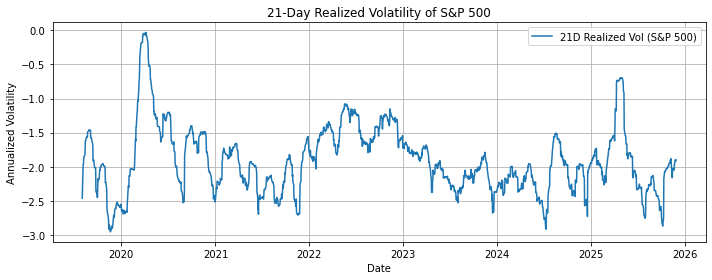

Max dispersion (21D realized vol) = -0.0322 on 2020-04-06

Splitting into train/test sets...
Train size: 1034, Test size: 556
Train period: 2019-08-02 to 2023-09-11
Test period:  2023-09-12 to 2025-11-26

Fitting OLS and Elastic Net models with TimeSeriesSplit CV...

Baseline OLS Test RMSE: 0.355907
Elastic Net Test RMSE: 0.345935
Best l1_ratio: 0.5
Best alpha:    0.02442053094548651

Reporting results...

=== RMSE COMPARISON (TEST SET) ===
OLS RMSE:        0.355907
Elastic Net RMSE:0.345935

=== TOP FEATURES BY |COEFFICIENT| (Elastic Net) ===
BAA10Y_LAG          0.278527
CREDIT_SPREAD       0.187802
EFFR_LAG           -0.150012
SP_RET_X_VXX       -0.110774
VOL_LAG             0.082871
CREDIT_SPREAD_SQ   -0.062385
VXX_RET            -0.011166
LQD_RET             0.002107
Name: coefficient, dtype: float64

=== TOP CV MODELS (Elastic Net) ===
   l1_ratio     alpha    cv_mse   cv_rmse
0      0.50  0.024421  0.195467  0.442117
1      0.55  0.024421  0.196683  0.443489
2      0.50  0.029471

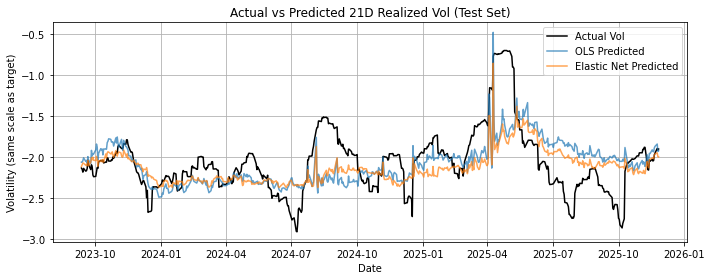


=== ELASTIC NET REGRESSION (TOP FEATURES ONLY) ===
SPX_21D_REALIZED_VOL ≈ 0.2785 * BAA10Y_LAG + 0.1878 * CREDIT_SPREAD + -0.1500 * EFFR_LAG + -0.1108 * SP_RET_X_VXX + 0.0829 * VOL_LAG + -0.0624 * CREDIT_SPREAD_SQ + -0.0112 * VXX_RET + 0.0021 * LQD_RET


In [6]:
# --------------------------------------------------------------------
# 7. MAIN PIPELINE
# --------------------------------------------------------------------

def main():
    # 1) Set parameters
    params = ModelParams()
    print("Model parameters:")
    print(params)

    # 2) Download data
    print("\nDownloading market data from Stooq (via pandas_datareader)...")
    market_df = download_market_data_stooq(params)

    print(f"Market data shape: {market_df.shape}")

    print("\nDownloading macro data from FRED...")
    macro_df = download_fred_data(params)
    print(f"Macro data shape: {macro_df.shape}")

    # 3) Merge & feature engineering
    print("\nMerging market and macro data...")
    merged_df = merge_market_macro(market_df, macro_df)
    print(f"Merged data shape: {merged_df.shape}")

    print("\nBuilding feature frame (Y and X variables)...")
    features_df = build_feature_frame(merged_df, params)
    print(f"Feature frame shape (before dropping NaNs): {features_df.shape}")

    # Drop remaining NaNs
    features_df = features_df.dropna()
    print(f"Feature frame shape (after dropping NaNs): {features_df.shape}")

    # 4) Diagnostics: check dispersion behaviour
    print("\nRunning dispersion diagnostics...")
    dispersion_diagnostics(features_df)

    # 5) Train/test split
    print("\nSplitting into train/test sets...")
    X_train, X_test, y_train, y_test = time_series_train_test_split(features_df, params)

    # 6) Fit models with time-series CV
    print("\nFitting OLS and Elastic Net models with TimeSeriesSplit CV...")
    results = fit_models_with_timeseries_cv(X_train, y_train, X_test, y_test, params)

    # 7) Report results
    print("\nReporting results...")
    report_results(results, params)


if __name__ == "__main__":
    main()
